# This notebook is a guide for classification task in MURA dataset. 

Import the modules

In [ ]:
# !/opt/conda/bin/python3.7 -m pip install --upgrade pip
# # !python -m pip install pip==20.1.1
# # !pip install pip==20.1.1
# !pip -V

In [ ]:
# !pip uninstall tensorflow -y
# !pip uninstall keras -y
# !pip install tensorflow-gpu===2.3.0
# !pip install keras==2.4.3
# # !pip install -U tensorflow-gpu==2.7.0
# # !pip install -U tensorflow==2.7.0

In [ ]:
# To restart kernal
# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
import tensorflow as tf
print("tf version: ",tf.__version__)
# tf.keras.__version__
print("tf.keras version: ",tf.keras.__version__)
import keras
print("keras.__version__: ",keras.__version__)

2021-12-25 18:36:40.685909: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-25 18:36:40.685951: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tf version:  2.3.0
tf.keras version:  2.4.0
keras.__version__:  2.4.3


In [ ]:
# # to solve error of "cannot import name 'Resize' from 'albumentations.augmentations.transforms'" of the next cell
# !pip install albumentations==0.5.2
# # !albumentations --V
# # !pip install -U git+https://github.com/albu/albumentations

In [2]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
import keras
import numpy as np
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import datetime
import numpy as np

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


****Some utility functions****

In [3]:
#To get the filenames for a task
def filenames(part,train=True):
    root='../input/mura-v11/'
    if train:
        csv_path="../input/mura-v11/MURA-v1.1/train_image_paths.csv"
    else:
        csv_path="../input/mura-v11/MURA-v1.1/valid_image_paths.csv"
    
    with open(csv_path, 'rb') as F:
        d = F.readlines()
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d] 
        else:
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

    #imgs= [x.replace("/", "\\") for x in imgs]
    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
    return imgs,labels


#To icrop a image from center
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


**Data augmentations**

In [4]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, CenterCrop, RandomGridShuffle,GridDistortion,ShiftScaleRotate  #CropAndPad, CropNonEmptyMaskIfExists, LongestMaxSize
)
from albumentations.augmentations.transforms import Resize
AUGMENTATIONS_TRAIN = Compose([
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.25, p=0.5),
        ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.1, 
            rotate_limit=18, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
        ToFloat(max_value=255),
        RandomGridShuffle(grid=(2,2)),
        GridDistortion(8),
])
AUGMENTATIONS_TEST = Compose([
    CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255),
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.25, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=18, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    RandomGridShuffle(grid=(2,2)),
    GridDistortion(8),
])

**Plotting the augmentations**

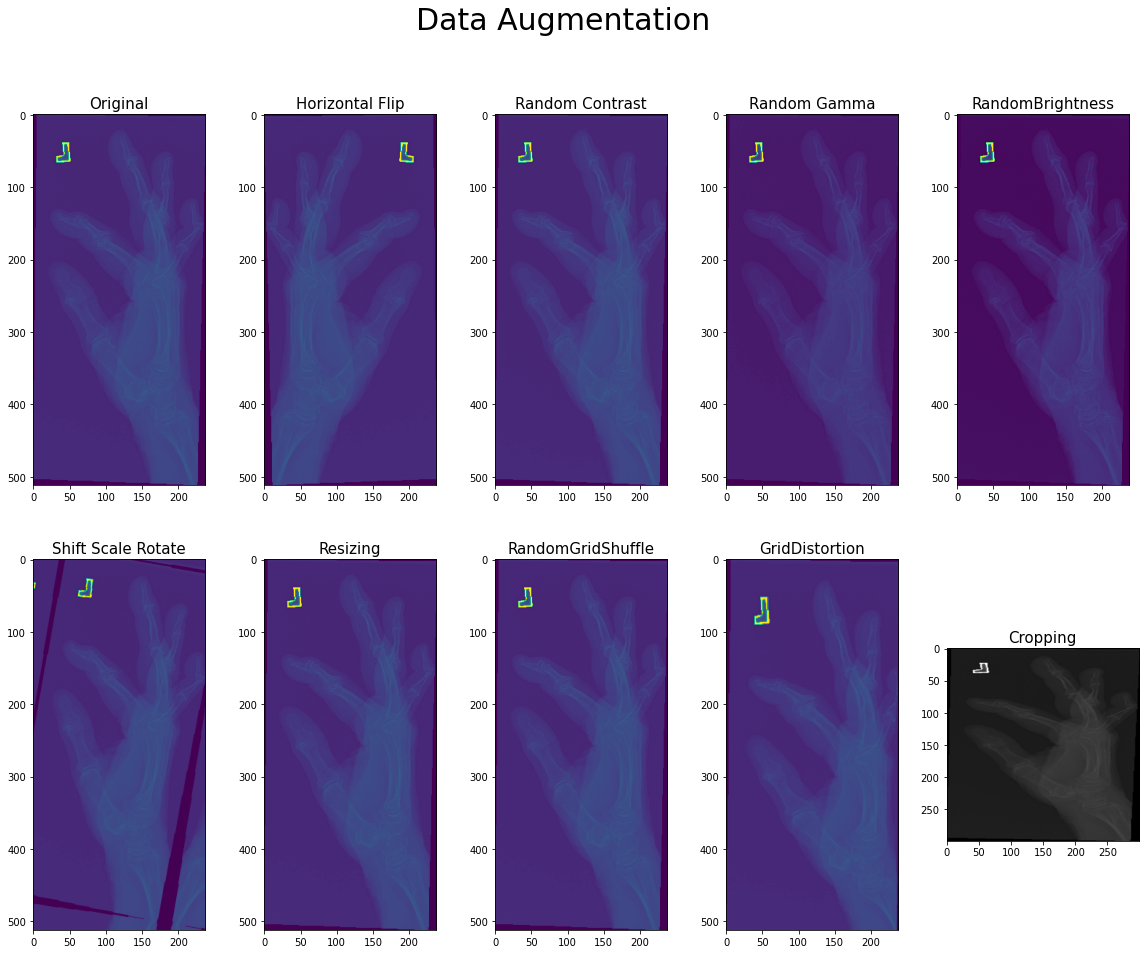

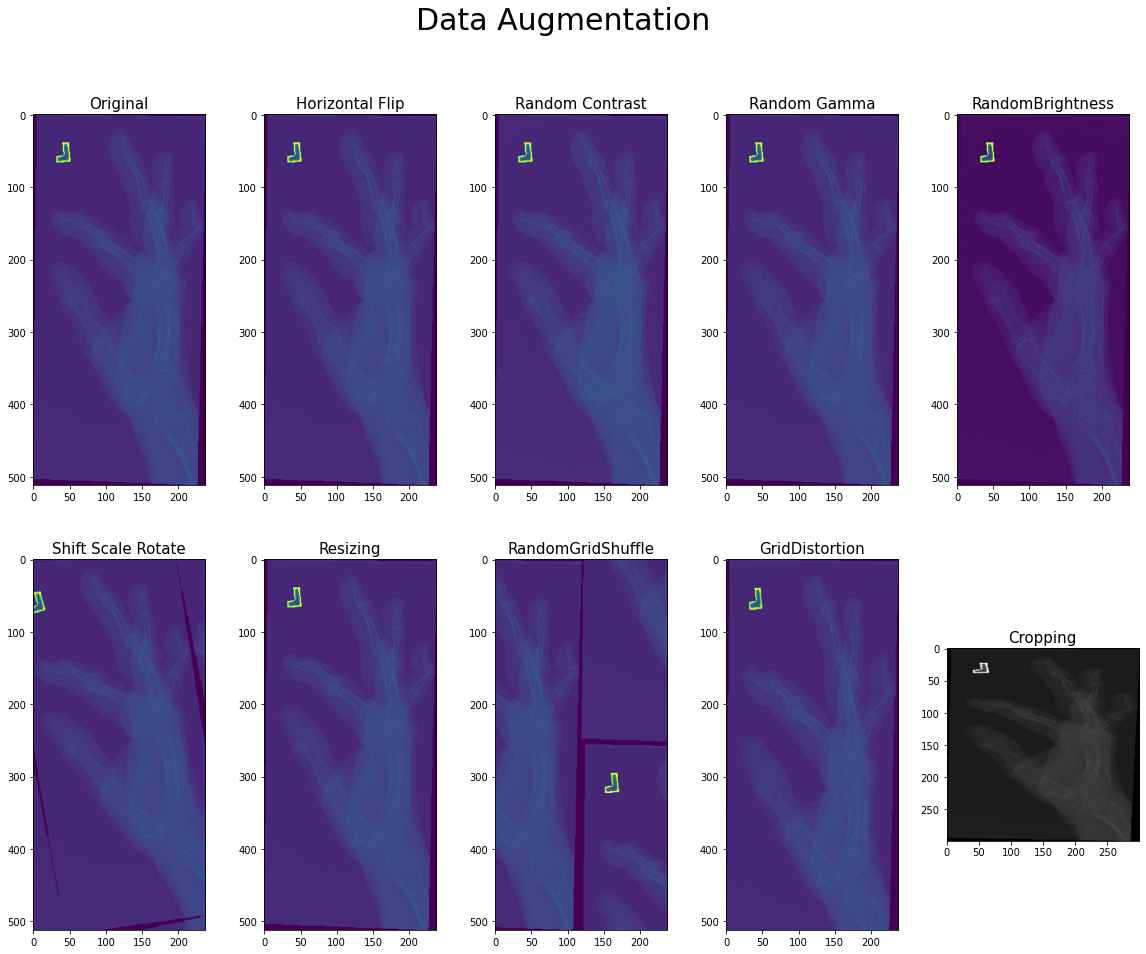

In [78]:
for i in range(2):
    albumentation_list =  [
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.25, p=0.5),
        ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.1, 
            rotate_limit=18, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
        ToFloat(max_value=255),
        RandomGridShuffle(grid=(2,2)),
        GridDistortion(8),

    ]
    root='../input/mura-v11/'
    chosen_image= imread(root+'MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png')
    img_matrix_list = []
    bboxes_list = []
    for aug_type in albumentation_list:
        img = aug_type(image = chosen_image)['image']
        img_matrix_list.append(img)
    img= resize(chosen_image,(300,300,3))
    img_matrix_list.append(img)
    img_matrix_list.append(crop_center(img,224,224))

    img_matrix_list.insert(0,chosen_image)    

    titles_list = ["Original","Horizontal Flip","Random Contrast","Random Gamma","RandomBrightness",
                   "Shift Scale Rotate","Resizing", "RandomGridShuffle", "GridDistortion","Cropping"]

    def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
        fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
        fig.suptitle(main_title, fontsize = 30)
        #fig.subplots_adjust(wspace=0.3)
        #fig.subplots_adjust(hspace=0.3)
        for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
            myaxes[i // ncols][i % ncols].imshow(img)
            myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        plt.show()

    plot_multiple_img(img_matrix_list, titles_list, ncols = 5)

**Creating data generator for training and testiing with augmentation:**

In [6]:
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size,transform) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.t= transform
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    x=[]
    for file in batch_x:
        img= imread(file)
        img= self.t(image=img)["image"]
        img= resize(img,(300,300,3))
        img= crop_center(img,224,224)
        x.append(img)
    x=np.array(x)/255.0
    y= np.array(batch_y)
    return x,y

**Some information about data:**

In [7]:
train_dir = "../input/mura-v11/MURA-v1.1/train"
validation_dir = '../input/mura-v11/MURA-v1.1/valid'
print("Total Training patients: ")
for i in os.listdir(train_dir) :
  print('Total Training patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/train/{}".format(i))))
print("\nTotal Validation patients: ")
for i in os.listdir(validation_dir) :
  print('Total Validation patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/valid/{}".format(i))))

# print("Total Training pics: ")
# for part in os.listdir(train_dir) :
#     imgs,labels= filenames(part=part) # train data
#     vimgs,vlabels= filenames(part=part,train=False) # validation data

#     print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
#     training_data= labels.count('positive')+labels.count('negative')
#     print("Total Training Data at {}: ".format(part), training_data)
#     print('\n')
#     print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
#     validation_data= vlabels.count('positive')+vlabels.count('negative')
#     print("Total Validation Data: ", validation_data)

Total Training patients: 
Total Training patients at XR_WRIST: 3267
Total Training patients at XR_FINGER: 1865
Total Training patients at XR_SHOULDER: 2694
Total Training patients at XR_HAND: 1945
Total Training patients at XR_FOREARM: 865
Total Training patients at XR_HUMERUS: 587
Total Training patients at XR_ELBOW: 1711

Total Validation patients: 
Total Validation patients at XR_WRIST: 207
Total Validation patients at XR_FINGER: 166
Total Validation patients at XR_SHOULDER: 173
Total Validation patients at XR_HAND: 159
Total Validation patients at XR_FOREARM: 129
Total Validation patients at XR_HUMERUS: 132
Total Validation patients at XR_ELBOW: 152


**Getting data using the utility functions**

In [8]:
########################################
# One of the seven listed below:
"""
XR_ELBOW
XR_FINGER
XR_FOREARM
XR_HAND
XR_HUMERUS
XR_SHOULDER
XR_WRIST
""" 
# training_bone = 'XR_HUMERUS'
########################################

part='XR_FINGER' # part to work with
imgs,labels= filenames(part=part) # train data
vimgs,vlabels= filenames(part=part,train=False) # validation data

print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
training_data= labels.count('positive')+labels.count('negative')
print(">> Total Training Data at {}: ".format(part), training_data)
print('\n')
print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
validation_data= vlabels.count('positive')+vlabels.count('negative')
print(">> Total Validation Data: ", validation_data)

y_data= [0 if x=='positive' else 1 for x in labels]
y_data= tf.keras.utils.to_categorical(y_data)
vy_data= [0 if x=='positive' else 1 for x in vlabels]
vy_data= tf.keras.utils.to_categorical(vy_data)

XR_FINGER Training positive : 1968 
 XR_FINGER Training negative : 3138
>> Total Training Data at XR_FINGER:  5106


XR_FINGER Validation positive : 247 
 XR_FINGER Validation negative : 214
>> Total Validation Data:  461


**Calculate class-weight to avoid class-imbalance :**

In [9]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_data, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


**Create Training and Test daat generator**

In [10]:
batch_size = 32
imgs, y_data = shuffle(imgs, y_data)
#vimgs, vy_data = shuffle(vimgs, vy_data)
my_training_batch_generator = My_Custom_Generator(imgs, y_data, batch_size,AUGMENTATIONS_TRAIN)
my_validation_batch_generator = My_Custom_Generator(vimgs, vy_data, batch_size,AUGMENTATIONS_TEST)

**Training callbacks**

In [11]:

checkpoint_path = "MURA_model@{}.h5".format(str(part))  
checkpoint_dir = os.path.dirname(checkpoint_path)
import json
json_log = open(str(part)+'_experiment_log_MURA.json', mode='wt', buffering=1)
my_callbacks = [
                    keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,  # Callback to save the Keras model or model weights at some frequency.
                                                    monitor='val_accuracy',
                                                    verbose=0,
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    mode='auto',
                                                    save_freq = 'epoch'),
                    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',     # Reduce learning rate when a metric has stopped improving.
                                                      factor=0.1,
                                                      patience=3,
                                                      min_delta=0.001,
                                                      verbose=1,
                                                      min_lr=0.000000001),
                    keras.callbacks.LambdaCallback(
                                                    on_epoch_end=lambda epoch,
                                                    logs: json_log.write(json.dumps({'epoch': epoch, 
                                                                                     'train_loss': logs['loss'],
                                                                                     'val_loss': logs['val_loss'],
                                                                                      'weights': ""}) + '\n'), # dict(model.get_weights()) - np.array(model.get_weights()).tolist()
                                                    on_train_end=lambda logs: json_log.close()),
                    keras.callbacks.TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                                                 histogram_freq=1, 
                                                 write_graph=True, 
                                                 write_images=False,    
                                                 update_freq='epoch', 
                                                 profile_batch=30, 
                                                 embeddings_freq=1,    
                                                 embeddings_metadata=None 
                                                 ),
                    keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=4,
                                                  mode="max",
                                                  baseline=None,
                                                  restore_best_weights=True,
)
                ]

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

2021-12-25 18:37:41.919731: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-12-25 18:37:41.923416: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-25 18:37:41.941195: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2021-12-25 18:37:41.941457: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcupti.so.10.1'; dlerror: libcupti.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-25 18:37:41.942520: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so
2021-12-25 18:37:41.950312: I 

In [ ]:
# np.array(model.get_weights()).tolist()

In [12]:
my_callbacks,d_class_weights

([<tensorflow.python.keras.callbacks.ModelCheckpoint at 0x7fc82feb09d0>,
 {0: 1.2972560975609757, 1: 0.8135755258126195})

**Create a model**

Second model try:


In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# # how to download a model from google drive
# ! conda install -y gdown
# import gdown
# url = 'https://drive.google.com/uc?id=1nx9aQ2NljNRAc6l58EOruDm8MZlvapGJ'
# output = '/tmp/MURA_model@XR_WRIST-2.h5'
# gdown.download(url, output, quiet=False)
# local_weights_file = output

In [61]:
##### Another model try: ########
base_model=keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.,
    input_shape=(224,224,3),
    include_top=False) # Do not include the ImageNet classifier at the top

# odl from original
for layer in base_model.layers[:280]:
    layer.trainable=False

# Freeze base model
# base_model.trainable = False

# Create a new model on top
input_image=keras.layers.Input((224,224,3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(input_image)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x=keras.layers.GlobalAveragePooling2D()(x)  ##### <-
# x=keras.layers.Flatten()(x)

# x=keras.layers.Dense(2048)(x) ###
# x=keras.layers.Activation(activation='relu')(x) ###
# x= keras.layers.Dropout(0.5)(x) ###
# x=keras.layers.Dense(2048)(x)
# x=keras.layers.Activation(activation='relu')(x)
# x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(1024)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(512)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_26  (None, 2048)              0         
_________________________________________________________________
dense_101 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
activation_2827 (Activation) (None, 1024)              0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 512)             

In [56]:
len(base_model.layers[0:])

311

*  *Training*

In [62]:
history=model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 52,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(validation_data // batch_size),
                   callbacks=my_callbacks)

Epoch 1/52
 29/159 [====>.........................] - ETA: 8:09 - loss: 0.7568 - accuracy: 0.5172

2021-12-25 23:21:52.074110: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 30/159 [====>.........................] - ETA: 8:09 - loss: 0.7531 - accuracy: 0.5208

2021-12-25 23:21:56.635746: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2021-12-25 23:21:56.644841: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-25 23:21:56.658814: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211225-183741/train/plugins/profile/2021_12_25_23_21_56
2021-12-25 23:21:56.663621: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211225-183741/train/plugins/profile/2021_12_25_23_21_56/b994df88d218.trace.json.gz
2021-12-25 23:21:56.676043: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211225-183741/train/plugins/profile/2021_12_25_23_21_56
2021-12-25 23:21:56.676155: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to lo

159/159 [==============================] - 655s 4s/step - loss: 0.6904 - accuracy: 0.5585 - val_loss: 0.6612 - val_accuracy: 0.5982
Epoch 2/52
159/159 [==============================] - 631s 4s/step - loss: 0.6624 - accuracy: 0.5753 - val_loss: 0.6571 - val_accuracy: 0.6473
Epoch 3/52
159/159 [==============================] - 626s 4s/step - loss: 0.6512 - accuracy: 0.5912 - val_loss: 0.6340 - val_accuracy: 0.6473
Epoch 4/52
159/159 [==============================] - 636s 4s/step - loss: 0.6388 - accuracy: 0.6009 - val_loss: 0.6769 - val_accuracy: 0.6183
Epoch 5/52
159/159 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.6070
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
159/159 [==============================] - 624s 4s/step - loss: 0.6425 - accuracy: 0.6070 - val_loss: 0.6543 - val_accuracy: 0.6429
Epoch 6/52
159/159 [==============================] - 638s 4s/step - loss: 0.6298 - accuracy: 0.6181 - val_loss: 0.6470 - val_accur

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# !kill 4805

In [63]:
# list all data in history
print(history.history.keys())
# history.history
# model.save("MURA_model@{}.h5".format(str(part)) )

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


**summarize history for accuracy**

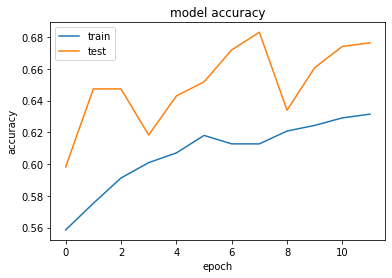

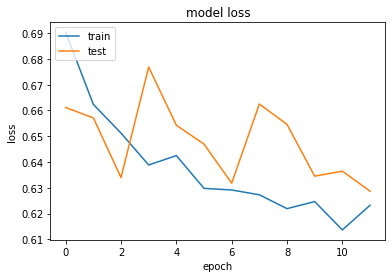

In [64]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Extracting some log to csv and json forms**

In [65]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = str(part)+'-history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = str(part)+'-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# model.get_weights()

In [66]:
# convert the model.get_weights() dict to a pandas DataFrame:     
model_weights_df = pd.DataFrame(model.get_weights()) 

# save to json:  
model_weights_file = str(part)+'-model_weights.json' 
with open(hist_json_file, mode='w') as f:
    model_weights_df.to_json(f)

# or save to csv: 
model_weights_file = str(part)+'-model_weights.csv'
with open(hist_csv_file, mode='w') as f:
    model_weights_df.to_csv(f)

In [ ]:
# from distutils.dir_util import copy_tree
# fromDirectory = '../kaggle/working'
# toDirectory = '../tempTry'
# copy_tree(fromDirectory,toDirectory)

In [ ]:
# path = 'MURA_model@XR_WRIST-2.h5' 
# model.save("MURA_model@XR_WRIST.h5")

**Evaluate the performance by cohen's kappa score**

In [67]:
# import tensorflow_addons as tfa
# model.save('MURA_model@XR_WRIST.h5')
m = tfa.metrics.CohenKappa(num_classes=2,sparse_labels=False)
# model=tf.keras.models.load_model(path)
y_pred=  model.predict(my_validation_batch_generator)

yp2 = np.argmax(y_pred,axis = 1)
ya2 = np.argmax(vy_data,axis = 1)
print(y_pred.shape,vy_data.shape)
m.update_state(ya2, yp2)
print('Final result: ', m.result().numpy())

(461, 2) (461, 2)
Final result:  0.32436442


In [68]:
vy_data2 = np.argmax(vy_data,axis=1)
vy_data2.shape

(461,)

In [69]:
yp2.shape

(461,)

In [70]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

**Confusion matrix for validation data:**

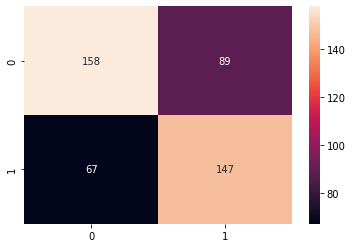

In [71]:
cm = confusion_matrix(vy_data2,yp2)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [72]:
print(classification_report(vy_data2,yp2))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       247
           1       0.62      0.69      0.65       214

    accuracy                           0.66       461
   macro avg       0.66      0.66      0.66       461
weighted avg       0.67      0.66      0.66       461



**Confusion matrix for trainning data**

In [73]:
y_pred=  model.predict(my_training_batch_generator)

In [75]:
yp3 = np.argmax(y_pred,axis=1)
y_true3 = np.argmax(y_data,axis=1)

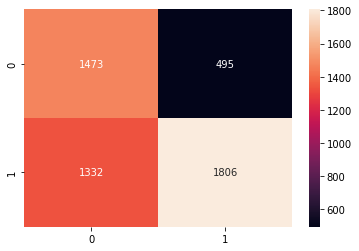

In [76]:
cm2 = confusion_matrix(y_true3,yp3)
sn.heatmap(cm2,annot=True,fmt='d')
plt.show()

In [77]:
print(classification_report(y_true3,yp3))

              precision    recall  f1-score   support

           0       0.53      0.75      0.62      1968
           1       0.78      0.58      0.66      3138

    accuracy                           0.64      5106
   macro avg       0.66      0.66      0.64      5106
weighted avg       0.68      0.64      0.65      5106

